옵트론텍
          Date  Close  STOCK  WALLET    PRINCIPAL       RATE VALUATION
0   2010-01-04    NaN    NaN     NaN       500000   0.000000    500000
1   2010-02-01    NaN    NaN     NaN      1000000  -7.139000    928610
2   2010-03-02    NaN    NaN     NaN      1500000  -1.603333   1475950
3   2010-04-01    NaN    NaN     NaN      2000000  -6.065750   1878685
4   2010-05-03    NaN    NaN     NaN      2500000  25.282600   3132065
..         ...    ...    ...     ...          ...        ...       ...
116 2019-09-02    NaN    NaN     NaN  6.25359e+07  -7.001508  58157425
117 2019-10-01    NaN    NaN     NaN  6.30359e+07   0.022725  63050205
118 2019-11-01    NaN    NaN     NaN  6.35359e+07  -2.300582  62074185
119 2019-12-02    NaN    NaN     NaN  6.40359e+07  26.930754  81281225
120 2020-01-02    NaN    NaN     NaN  6.54568e+07  22.488529  80177125

[121 rows x 7 columns]


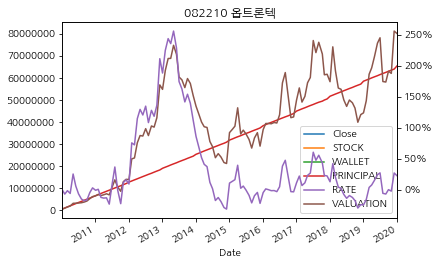

In [33]:
"""
python get_stock_value.py 종목코드
적으면 표준 출력으로 결과 나옴.
"""
import os
import sys
import datetime as dt
import pandas as pd
import sqlite3
import matplotlib.ticker as mtick
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as dates
%matplotlib inline
# 폰트 설정
mpl.rc('font', family='NanumGothic')
# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

sys.argv[1] = '082210'
# 수수료 계산 함수.
# 수수료는 매수/매도 시, Tax on sale. KOSPI 0.25, KOSDAQ 0.25
def F_FEE(Get_Date):
    FEE_STD = dt.datetime(2019, 6, 1, 0, 0, 0)
    FEE_STD = FEE_STD.__format__("%Y-%m-%d %H:%M:%S")
    if Get_Date > FEE_STD:
        return 0.13
    else:
        return 0.18

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return conn

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

CONN = create_connection('./db/finance.db')
BT = create_connection('./db/backtest.db')

COUNTRY = "KR"
if len(sys.argv[1]) > 1:
    SYM = sys.argv[1]
else:
    SYM = '005930'
SYM = str(SYM)
# COUNTRY = sys.argv[2]

# SYM 변수가 finance.db에 없으면 에러 발생..
DF = pd.read_sql('select * from \"' + SYM + '\"', con = CONN, index_col="Date")

# Create Backtest Table.
# if exist, read latest record.
def checkTableExists(dbcon, tablename):
    dbcur = dbcon.cursor()
    dbcur.execute("""
        SELECT COUNT(*)
        FROM sqlite_master
        WHERE type = '{0}'
        """.format(tablename.replace('\'', '\'\'')))
    if dbcur.fetchone()[0] == 1:
        dbcur.close()
        return True
    dbcon.commit()

    #commit the changes to db			
    dbcur.close()
    return False
"""

if (checkTableExists(BT, SYM)):
    print("Table is exist")
else:
    print("Table is not exist, Create Table " + SYM)
    # create_table(BT, SYM)
"""
# 매월 투입금
BUDGET = 500000
# 거스름돈
WALLET = 0
# 보유주식 수
STOCK = 0
# 평가액
PRINCIPAL = 0

COLS_TMP = ['Date', 'Close', 'STOCK', 'WALLET', 'PRINCIPAL', 'RATE', 'VALUATION']
RESULT_DF = pd.DataFrame(columns=COLS_TMP)

for year in range(2010, 2021):
    for month in range(1, 13):
        for day in range(1, 28):
            date = dt.datetime(year, month, day, 0, 0, 0)
            date = date.__format__("%Y-%m-%d %H:%M:%S")

            if date in DF.index:
                # 주식 매수
                STOCK = (BUDGET + WALLET) // ((DF.at[date, 'Close'])) + STOCK
                WALLET = (BUDGET + WALLET) % ((DF.at[date, 'Close']))
                PRINCIPAL += BUDGET
                VALUATION = DF.at[date, 'Close'] * STOCK + WALLET
                RATE = ((VALUATION / PRINCIPAL) - 1)
                date = dt.datetime(year, month, day)
                RESULT_DF = RESULT_DF.append({
                    'Date':date,
                    'PRINCIPAL':PRINCIPAL,
                    'RATE':(RATE*100),
                    'VALUATION':VALUATION},
                    ignore_index=True)
                """
                print('{}	{}	{}	{}	{}	{:.2}	{}'.format(
                    str(date),
                    DF.at[date, 'Close'],
                    STOCK,
                    WALLET,
                    PRINCIPAL,
                    RATE,
                    VALUATION
                    )
                    )
                """
                break
    PRINCIPAL = PRINCIPAL + (PRINCIPAL * 0.017 * 0.846)
TITLE = pd.read_sql('select Symbol, Name from KRX where Symbol like \"' + SYM + '\"', con = CONN, index_col="Symbol")
print(TITLE.at[SYM, 'Name'])
CONN.close()
BT.close()
print(RESULT_DF)
RESULT_DF = RESULT_DF.set_index('Date')
PLOT = RESULT_DF.plot(secondary_y=['RATE'], mark_right=False)
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
PLOT.set_title(SYM + ' ' + TITLE.at[SYM, 'Name'])
PLOT.right_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
PLOT.ticklabel_format(axis='y', style='plain')